In [45]:
from env import host, username, password, get_db_url
import os
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
import seaborn as sns
import matplotlib.pyplot as plt

import lux
from pandas_profiling import ProfileReport

pd.set_option('display.float_format', lambda x: '%.3f' % x)

Pandas backend loaded 1.3.4
Numpy backend loaded 1.20.3
Pyspark backend loaded 3.2.1
Python backend loaded


In [4]:
def acquire_zillow_data(use_cache=True):
    if os.path.exists('zillow.csv') and use_cache:
        print('Using cached CSV')
        return pd.read_csv('zillow.csv')
    print('Acquiring data from SQL database')
    df = pd.read_sql('''
                        SELECT bedroomcnt AS beds, 
                               bathroomcnt AS baths, 
                               calculatedfinishedsquarefeet AS area, 
                               taxvaluedollarcnt AS assessed_value, 
                               yearbuilt AS year_built, 
                               fips AS county         
                        FROM properties_2017
                            JOIN propertylandusetype USING (propertylandusetypeid)
                            JOIN predictions_2017 USING(parcelid)
                        WHERE propertylandusedesc IN ('Single Family Residential', 
                                                        'Inferred Single Family Residential')
                            AND transactiondate LIKE '2017%%';
                    
                     '''
                    , get_db_url('zillow'))
    df.to_csv('zillow.csv', index=False)
    
    return df

In [5]:
df = acquire_zillow_data()

Using cached CSV


In [6]:
def describe_data(df):
    '''
    This function takes in a pandas dataframe and prints out the shape, datatypes, number of missing values, 
    columns and their data types, summary statistics of numeric columns in the dataframe, as well as the value counts for categorical variables.
    '''
    # Print out the "shape" of our dataframe - rows and columns
    print(f'This dataframe has {df.shape[0]} rows and {df.shape[1]} columns.')
    print('')
    print('--------------------------------------')
    print('--------------------------------------')
    
    # print the datatypes and column names with non-null counts
    print(df.info())
    print('')
    print('--------------------------------------')
    print('--------------------------------------')

    # print the number of missing values per column and the total
    print('Null Values: ')
    missing_total = df.isnull().sum().sum()
    missing_count = df.isnull().sum() # the count of missing values
    value_count = df.isnull().count() # the count of all values
    missing_percentage = round(missing_count / value_count * 100, 2) # percentage of missing values
    missing_df = pd.DataFrame({'count': missing_count, 'percentage': missing_percentage}) # create df
    print(missing_df)
    print(f' \n Total Number of Missing Values: {missing_total} \n')
    df_total = df[df.columns[:]].count().sum()
    proportion_of_nulls = round((missing_total / df_total), 4)
    print(f' Proportion of Nulls in Dataframe: {proportion_of_nulls}\n') 
    print('--------------------------------------')
    print('--------------------------------------')

    # print out summary stats for our dataset
    print('Here are the summary statistics of our dataset')
    print(df.describe().applymap(lambda x: f"{x:0.3f}"))
    print('')
    print('--------------------------------------')
    print('--------------------------------------')

    print('Relative Frequencies: \n')
    # Display top 5 values of each variable within reasonable limit
    limit = 25
    for col in df.columns:
        if df[col].nunique() < limit:
            print(f'Column: {col} \n {round(df[col].value_counts(normalize=True).nlargest(5), 3)} \n')
        else: 
            print(f'Column: {col} \n')
            print(f'Range of Values: [{df[col].min()} - {df[col].max()}] \n')
        print('------------------------------------------')
        print('--------------------------------------')
    

In [7]:
describe_data(df)

This dataframe has 52441 rows and 6 columns.

--------------------------------------
--------------------------------------
<class 'lux.core.frame.LuxDataFrame'>
RangeIndex: 52441 entries, 0 to 52440
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   beds            52441 non-null  float64
 1   baths           52441 non-null  float64
 2   area            52359 non-null  float64
 3   assessed_value  52440 non-null  float64
 4   year_built      52325 non-null  float64
 5   county          52441 non-null  float64
dtypes: float64(6)
memory usage: 2.4 MB
None

--------------------------------------
--------------------------------------
Null Values: 
                count  percentage
beds                0       0.000
baths               0       0.000
area               82       0.160
assessed_value      1       0.000
year_built        116       0.220
county              0       0.000
 
 Total Number of Missing Value

### An Assessment of Acquisition

- The Zillow Dataframe has several observations to draw insight through
- Very few null values, these rows will be dropped altogether. 
- Currently all columns are Float64. This must change. 
- Counties can be one-hot encoded, but care must be given to ensure Los Angeles is not dropped as nearly 65% of the sample is there. 
- Yearbuilt can be used to calculate age, which may be more useful as it will then be continuous.
- Median build year is 1961, which is thankfully close to the mean, so I'm not worried about dates having some absurd errors.
- Not particularly interested in Victorian Era (< 1902) homes, as they may have no bathrooms and hardly fit the profile of a family residential, as a result.
- Average number of baths 2, beds 3.
- Min number of beds and baths 0. 0 Beds is understandable for a single person as it could be a studio; 0 baths is nonsensical. 
   - The problem with even considering a studio as a factor here is that it goes against single-family zoning, which refers to a residential area where only one housing unit can be built on a given parcel of land. In fact, there is a Southern California suburban staple of a home with no shared walls — in other words, not a duplex, triplex or multiunit complex. Yet another big flag for data integrity and "human error" present in the data frame. It's more comfortable to assume that each of the values in the rows where both of those meet 0 are also inaccurate, and so the model would likely benefit from their exclusion.
- Average assessed_value over a half million. The difference between max and mins is a clear indication that there will be skewing and outliers. 
- Of course, the minimum assessment_value is a no-brainer when it comes to its validity. Good luck even having a 4 sq ft patch of grass to call your own for less than $1000. 

### Zillow Preparation Station

In order to proceed toward drawing meaningful conclusions about this data, there's some cleaning that needs to be done. 
First I'll check out some univariate distributions after removing the nulls, given the inconsequentiality of their representation.

In [ ]:
# shape before nulls are gone. 
df.shape

In [53]:
df

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

In [52]:
#import mitosheet
#mitosheet.sheet(df, view_df=True)

In [ ]:
#just in case there are blanks
df = df.replace(r'^\s*$', np.NaN, regex=True)
# drop all nulls, for an affect of .00586 on data
df.dropna(axis=0, how='any', inplace=True)

#shape after nulls are gone. Only lost 122 rows.
df.shape

In [40]:
def generate_hist(df, var):
    '''
    Helper function. Given a dataframe DF and a variable to plot, this function will 
    generate and display a histogram for that variable.
    '''
    print ('Distribution of ' + var)
    df[var].hist()
    plt.grid(False)
    plt.xlabel(var)
    plt.ylabel('Number of Properties')
    plt.show()

def explore_univariate(df, categorical_vars, quantitative_vars):
    '''
    This function takes in categorical and quantitative (continuous) variables from a dataframe.
    It returns a bar plot for each categorical variable
    and a histogram and boxplot for each continuous variable.
    '''
    # plot frequencies for each categorical variable
    for var in categorical_vars: 
        print('Bar Plot of ' + var)
        bp = df[var].hist()
        plt.xlabel(var)
        plt.ylabel('count')
        bp.grid(False)
        plt.show()
        
    # print histogram for each continuous variable
    for var in quantitative_vars:
        generate_hist(df, var)
        # creating boxplot for each variable
        plt.figure(figsize=(10,5))
        sns.boxplot(x=var, data=df,  palette="twilight_shifted")
        plt.title('Distribution of ' + var)
        plt.show()


In [ ]:
categorical_vars = ['county']
quantitative_variables = ['beds', 'baths', 'area', 'assessed_value', 'year_built']

In [ ]:
explore_univariate(df, categorical_vars, quantitative_variables)

In [8]:
def remove_outliers(df, k, col_list):
    for col in col_list:
        
        q1, q3 = df[col].quantile([.25, .75])
        
        iqr = q3 - q1
        
        upper_bound = q3 + k * iqr
        lower_bound = q1 - k * iqr
        
        df = df[(df[col] > lower_bound) & (df[col] < upper_bound)]
        
    return df

In [9]:
# modifyfips
df['county'] = df.county.apply(lambda county: '0' + str(int(county)))
df['county'].replace({'06037': 'los_angeles', '06059': 'orange', '06111': 'ventura'}, inplace=True)

In [10]:
# to satisfy my curiosity, I'm gonna see how many outliers there are pure county.
# Select all rows and columns where county_name == orange
orange = df[df['county'] == 'orange']
ventura = df[df['county'] == 'ventura']
los_angeles = df[df['county'] == 'los_angeles']

In [11]:
# before removing outliers.
orange.shape, ventura.shape, los_angeles.shape

((14136, 6), (4395, 6), (33910, 6))

In [12]:
orange = remove_outliers(orange, 1.5, ['beds', 'baths', 'area', 'assessed_value', 'year_built'])
ventura = remove_outliers(ventura, 1.5, ['beds', 'baths', 'area', 'assessed_value', 'year_built'])
los_angeles = remove_outliers(los_angeles, 1.5, ['beds', 'baths', 'area', 'assessed_value', 'year_built'])

In [13]:
# after removing outliers.
print(orange.shape, ventura.shape, los_angeles.shape)
print(f'Loss of rows in Orange = {14082-12189}')
print(f'Loss of rows in Ventura = {4358-3824}')
print(f'Loss of rows in Los Angeles = {33879-26298}')
print(f'Total loss of rows when separated by county = {1893 + 534 + 7581}')
print(f'Original Number of Rows after nulls removed = 52319')
print(f'Percentage Loss for DataFrame if Combined= {round((52319-42311)/52319*100,2)} %')

(12189, 6) (3824, 6) (26297, 6)
Loss of rows in Orange = 1893
Loss of rows in Ventura = 534
Loss of rows in Los Angeles = 7581
Total loss of rows when separated by county = 10008
Original Number of Rows after nulls removed = 52319
Percentage Loss for DataFrame if Combined= 19.13 %


In [14]:
# now the same thing on the entire dataframe to see if the results are the same. 
print(f' DF Shape before removing outliers {df.shape}')
#still in tact.

 DF Shape before removing outliers (52441, 6)


In [15]:
df = remove_outliers(df, 1.5, ['beds', 'baths', 'area', 'assessed_value', 'year_built'])

In [16]:
df.shape
print(f'Total loss of rows = {52319 - 45238}')
print(f'Percentage Loss for DataFrame= {round((52319 - 45238)/52319*100,2)} %')

Total loss of rows = 7081
Percentage Loss for DataFrame= 13.53 %


In [17]:
# copy current working dataframe; changes won't be reflected on original df in case I want to go back. 
df_experiment = df.copy()

In [18]:
orange_juice = orange.copy()
ventura_gravy = ventura.copy()
los_angeles_les = los_angeles.copy()

I'm very interested in the differences between these figures. ~14% VS ~19%. Because value is based in proximity, among many other factors, I find controlling for each of the counties individually to be an interesting and plausibly more accurate approach. I will test this statistically later, first I need to make sure I merge the county dataframes into a new one properly. 

In [19]:
from functools import reduce
dfs = [orange_juice, ventura_gravy, los_angeles_les]
df_cronenberg = reduce(lambda left,right: pd.merge(left,right,on='county'), dfs)

In [20]:
# that code above didn't work. I'll try what I know from dummies, but along rows
df_whoops = pd.concat([orange_juice, ventura_gravy], axis=0)

In [21]:
df_hope = pd.concat([df_whoops, los_angeles_les], axis=0)

In [22]:
df_hope.shape #AHAHA It worked! 

(42310, 6)

In [23]:
describe_data(df_hope)

This dataframe has 42310 rows and 6 columns.

--------------------------------------
--------------------------------------
<class 'lux.core.frame.LuxDataFrame'>
Int64Index: 42310 entries, 0 to 52440
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   beds            42310 non-null  float64
 1   baths           42310 non-null  float64
 2   area            42310 non-null  float64
 3   assessed_value  42310 non-null  float64
 4   year_built      42310 non-null  float64
 5   county          42310 non-null  object 
dtypes: float64(5), object(1)
memory usage: 2.3+ MB
None

--------------------------------------
--------------------------------------
Null Values: 
                count  percentage
beds                0       0.000
baths               0       0.000
area                0       0.000
assessed_value      0       0.000
year_built          0       0.000
county              0       0.000
 
 Total Number of M

In [24]:
describe_data(df)

This dataframe has 45241 rows and 6 columns.

--------------------------------------
--------------------------------------
<class 'lux.core.frame.LuxDataFrame'>
Int64Index: 45241 entries, 0 to 52440
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   beds            45241 non-null  float64
 1   baths           45241 non-null  float64
 2   area            45241 non-null  float64
 3   assessed_value  45241 non-null  float64
 4   year_built      45241 non-null  float64
 5   county          45241 non-null  object 
dtypes: float64(5), object(1)
memory usage: 2.4+ MB
None

--------------------------------------
--------------------------------------
Null Values: 
                count  percentage
beds                0       0.000
baths               0       0.000
area                0       0.000
assessed_value      0       0.000
year_built          0       0.000
county              0       0.000
 
 Total Number of M

Here are the summary statistics of our DF_HOPE
            beds      baths       area assessed_value year_built
count  42311.000  42311.000  42311.000      42311.000  42311.000
mean       3.199      2.090   1682.471     371944.307   1961.929
std        0.778      0.709    600.413     245359.675     19.071
min        2.000      1.000    152.000       1000.000   1919.000
25%        3.000      2.000   1236.000     169314.000   1950.000
50%        3.000      2.000   1558.000     337909.000   1959.000
75%        4.000      2.500   2027.500     520918.000   1975.000
max        5.000      4.000   3902.000    1255855.000   2015.000

Here are the summary statistics of our 'original' dataset
            beds      baths       area assessed_value year_built
count  45238.000  45238.000  45238.000      45238.000  45238.000
mean       3.215      2.111   1707.257     373888.042   1962.638
std        0.789      0.727    613.148     244706.175     21.270
min        2.000      1.000    152.000       1000.000   1910.000
25%        3.000      2.000   1243.000     175041.000   1950.000
50%        3.000      2.000   1577.000     337694.000   1960.000
75%        4.000      2.500   2071.000     523000.000   1977.000
max        5.000      4.000   3566.000    1124001.000   2016.000

Relative Frequencies: DF HOPE 

Column: beds 
 3.000   0.495
4.000   0.282
2.000   0.176
5.000   0.047
Name: beds, dtype: float64 

------------------------------------------
--------------------------------------
Column: baths 
 2.000   0.480
1.000   0.190
3.000   0.187
2.500   0.090
1.500   0.019
Name: baths, dtype: float64     



--------------------------------------
Relative Frequencies: OG DF

Column: beds 
 3.000   0.486
4.000   0.288
2.000   0.175
5.000   0.051
Name: beds, dtype: float64 

------------------------------------------
--------------------------------------
Column: baths 
 2.000   0.466
3.000   0.207
1.000   0.191
2.500   0.084
4.000   0.023
Name: baths, dtype: float64 

------------------------------------------

Highly similar except baths are distributed with more baths per property in DF Hope 

In [ ]:
df_hope

In [32]:
df_hope = df_hope.sort_values(by='area', ascending=True)

In [33]:
df_hope.head(20)

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

Data Validity once again comes into question. For the millionth time. So, a piece of property  in los_angeles with an area of 152 also has 5 beds and 2 baths. 400 square feet would effectively be the size of a two-car garage. It seems I need to be less forgiving with my outlier syste. See also 

In [36]:
df_hope = df_hope.drop(labels=51075, axis=0)
#alright, that one is gone. 

Bar Plot of county


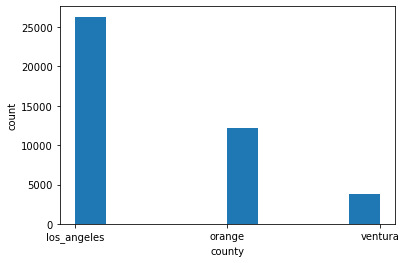

Distribution of beds


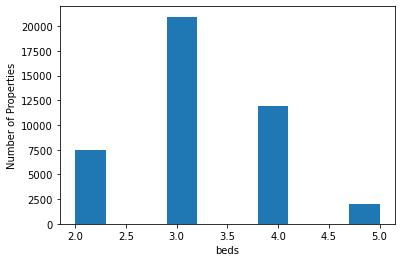

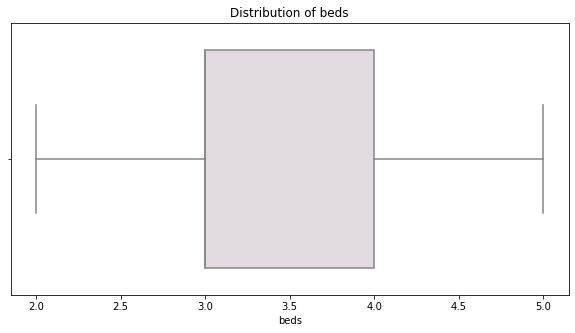

Distribution of baths


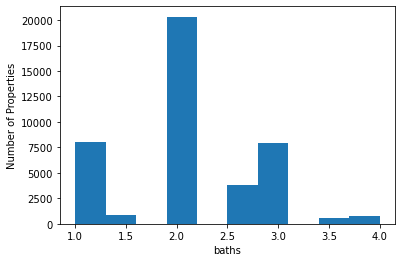

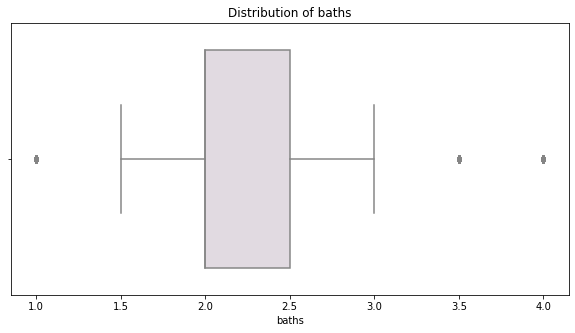

Distribution of area


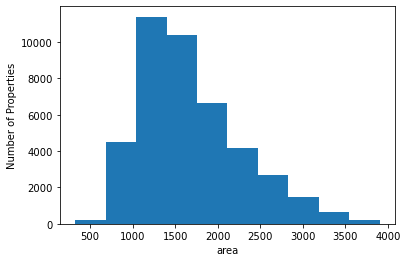

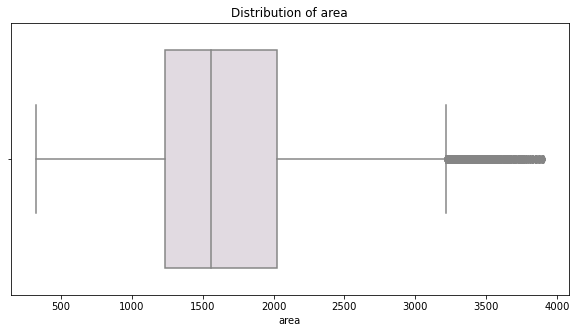

Distribution of assessed_value


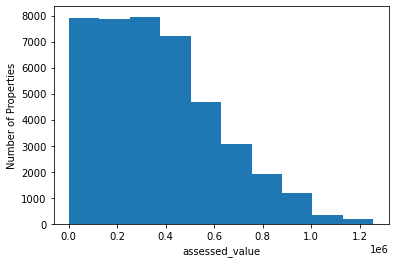

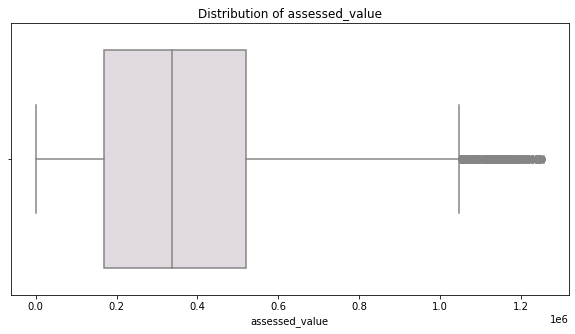

In [43]:
categorical_vars = ['county']
quantitative_variables = ['beds', 'baths', 'area', 'assessed_value']

explore_univariate(df_hope, categorical_vars, quantitative_variables)

Bar Plot of county


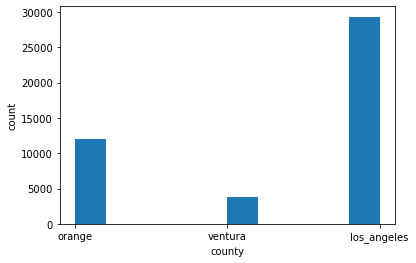

Distribution of beds


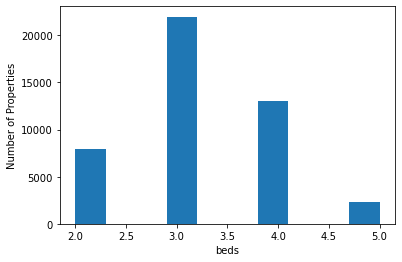

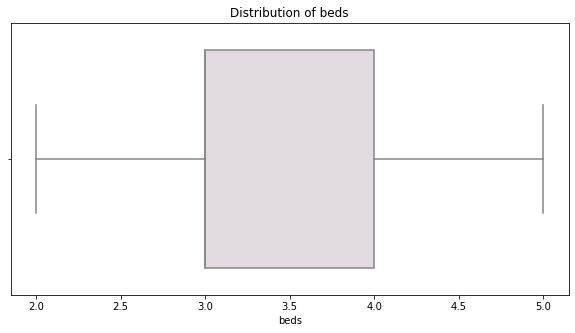

Distribution of baths


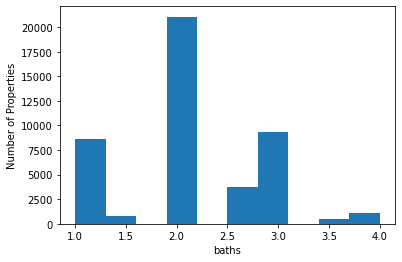

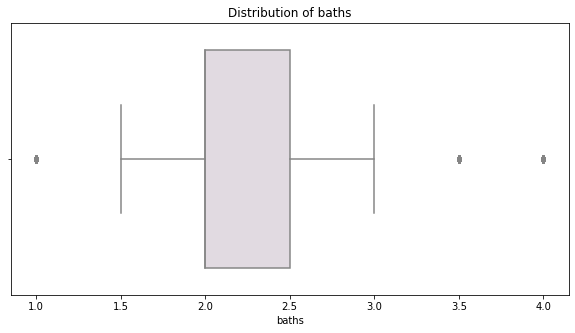

Distribution of area


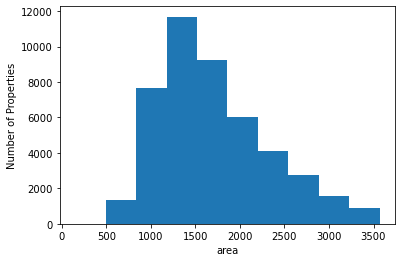

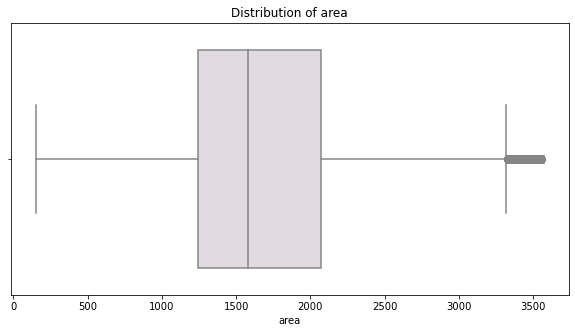

Distribution of assessed_value


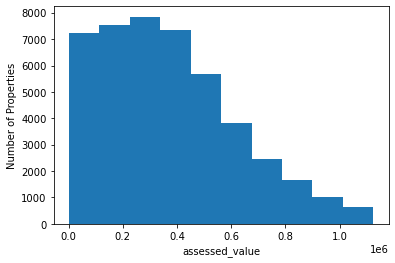

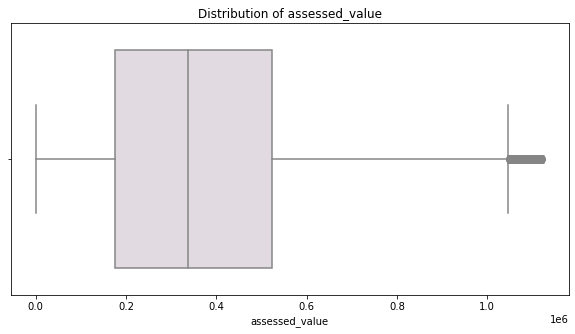

In [44]:
categorical_vars = ['county']
quantitative_variables = ['beds', 'baths', 'area', 'assessed_value']

explore_univariate(df, categorical_vars, quantitative_variables)

In [48]:
report = ProfileReport(df_hope)
#report

In [ ]:
# group by number of beds and check number of baths and then run statistical tests based on that. 

In [54]:
dummy_df=pd.get_dummies(df['county'], dummy_na=False, 
                        drop_first=False)

In [57]:
dummy_df = dummy_df.drop(columns='ventura')

In [61]:
df = pd.concat([df, dummy_df], axis = 1)

In [ ]:
df

In [63]:
import mitosheet
mitosheet.sheet(df, view_df=True)

AttributeError: 'LuxDataFrame' object has no attribute 'dtype'

In [ ]:
def plot_categorical_and_continuous_vars(categorical_var, continuous_var, df):
    """
    Accepts a string name of a categorical variable, 
    a string name from a continuous variable and their dataframe
    then it displays 4 different plots.
    """
   # fig, axes = plt.subplots(2, 2, sharex=False, figsize=(10, 12))
    
    #plt.subplot(131)
    plt.suptitle(f'{continuous_var} by {categorical_var}', fontsize=18)
    
    sns.lineplot(x=categorical_var, y=continuous_var, data=df)
    plt.xlabel(categorical_var, fontsize=12)
    plt.ylabel(continuous_var, fontsize=12)
    
   # plt.subplot(132)
    sns.catplot(x=categorical_var, y=continuous_var, data=df, kind='box', palette='deep')
    plt.xlabel(categorical_var, fontsize=12)
    plt.ylabel(continuous_var, fontsize=12)
    
   # plt.subplot(133)
    sns.catplot(x=categorical_var, y=continuous_var, data=df, kind="swarm", palette='muted')
    plt.xlabel(categorical_var, fontsize=12)
    plt.ylabel(continuous_var, fontsize=12)
    
   # plt.subplot(134)
    sns.catplot(x=categorical_var, y=continuous_var, data=df, kind="bar", palette='dark')
    plt.xlabel(categorical_var, fontsize=12)
    plt.ylabel(continuous_var, fontsize=12)
